![](https://img.shields.io/badge/Community-Contribution-%20?color=grey&labelColor=yellow)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/SWOT_PIXC_PhaseUnwrap_localmachine.ipynb). 

_Note: This notebook uses Version C (2.0) of SWOT data that was available at the time of this notebook's development. The most recent data is now available as Version D for SWOT collections._
_The last Version C measurement will be until May 3rd, 2025. The first Version D measurement starts on May 5th, 2025._

# SWOT PIXC Dataset Phase Unwrapping on a local machine

## How to manually fix a phase unwrapping error in PIXC data

### Requirement:
Local compute environment e.g. laptop, server: this tutorial can be run on your local machine.

### Learning Objectives:
- Learn how to identify phase unwrapping errors
- Learn how to correct a phase unwrapping error by adding multiples of 2pi to the phase
- Access SWOT PIXC data products (archived in NASA Earthdata Cloud) by downloading to local machine
- Visualize accessed data, identify phase unwrapping error, break phase unwrapping regions, find best ambiguity, correct the height and locations

#### SWOT Level 2 KaRIn High Rate Version C (aka 2.0) Datasets:

1. **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0

### Background
This notebook targets expert users, and assumes the reader is already familiarized with terms like "layover", "phase unwrapping", and "backscatter"/"phase". For detailed background on SWOT definitions and conventions, see the [SWOT User Handbook](https://deotb6e7tfubr.cloudfront.net/s3-edaf5da92e0ce48fb61175c28b67e95d/podaac-ops-cumulus-docs.s3.us-west-2.amazonaws.com/web-misc/swot_mission_docs/D-109532_SWOT_UserHandbook_20240502.pdf?A-userid=None&Expires=1721426470&Signature=gL0nYzYt~reTLeb-erAnAlDbZNrk37noc4B8dhNkCQHZdCa-Hx4cwYqYYhEncjIRcHXmuHx5PYxf3qzLTzBWdtcL-Lz2ZxOKwnkXriBdWSg0yKpXSrRmW5RDYC0ktmAD2ySrAJ5niAmj5ehmWjNm~c9bPKf2tg-mQN6KIBsfRRt50borWFRfBnj75FP2R8s6V9Mx46lXRiGOKmPBSzE6b4QJ-2n71n5KElDuGWJofg5ViTTVL43R7ITA5SJ26zZVuCwQX0Qxmf6smVtHVSsjYjbCbNK8Wx6EywNa-LhnAqZJNLxZj-OvECX9TrsLjN2pX32G-8E9HdGEYDXcifOMyA__&Key-Pair-Id=KX5J11OFWFB3T)
.

_Notebook Author: Brent Williams (NASA JPL, July 2024)_

_Last updated: 18 July 2024_
  

### Libraries Needed

In [1]:
import glob
import h5netcdf
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import earthaccess
import scipy.ndimage
import contextily as cx
import dask  # I was getting errors not having this

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. If you don't already have one, please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use `earthaccess` to authenticate your login credentials below.

In [2]:
auth = earthaccess.login()

#### **1. Water Mask Pixel Cloud NetCDF**

#### Search for data collection and time of interest

In [3]:
pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0', 
                                        granule_name = '*525_020_171R_*') # Santana do Sobrado, cycle 525 pass 020 tile 171R

Granules found: 1


Let's download one data file! Since `earthaccess.download` requires the input to be in list format, we need to enclose the single file in brackets.

In [4]:
earthaccess.download([pixc_results[0]], "./data_downloads")

 Getting 1 granules, approx download size: 0.4 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['data_downloads\\SWOT_L2_HR_PIXC_525_020_171R_20230519T064311_20230519T064322_PGC0_01.nc']

#### Open data using xarray

The pixel cloud netCDF files are formatted with three groups titled, "pixel cloud", "tvp", or "noise" (more detail [here](https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20200810.pdf)). We will focus on the "pixel cloud" group. In order to access the coordinates and variables within the file, a group must be specified when calling xarray open_dataset.

In [5]:
ds_PIXC = xr.open_mfdataset("data_downloads/SWOT_L2_HR_PIXC_*525_020_171R*.nc", group = 'pixel_cloud', engine='h5netcdf')
ds_PIXC

<xarray.Dataset>
Dimensions:                                (points: 4584708, complex_depth: 2,
                                            num_pixc_lines: 3253)
Coordinates:
    latitude                               (points) float64 dask.array<chunksize=(4584708,), meta=np.ndarray>
    longitude                              (points) float64 dask.array<chunksize=(4584708,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 dask.array<chunksize=(4584708,), meta=np.ndarray>
    range_index                            (points) float64 dask.array<chunksize=(4584708,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 dask.array<chunksize=(4584708, 2), meta=np.ndarray>
    power_plus_y                           (points) float32 dask.array<chunksize=(4584708,), meta=np.ndarray>
    power_minus_y                          (points) float32 dask.array<chunksize=(4584708,), meta=np.ndarray>
    coherent_power                         (points) float32 dask.array<chunksize=(4584708,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 dask.array<chunksize=(3253,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 dask.array<chunksize=(3253,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 dask.array<chunksize=(3253,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 dask.array<chunksize=(3253,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 dask.array<chunksize=(3253,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 dask.array<chunksize=(3253,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3253
    interferogram_size_range:    4598
    looks_to_efflooks:           1.5394042762332962
    num_azimuth_looks:           7.0
    azimuth_offset:              9

#### Plot the PIXC data only for good/detected water


In [6]:
# set Coordinate Reference System (CRS) as WGS84 for contextily basemap
crs='EPSG:4326'

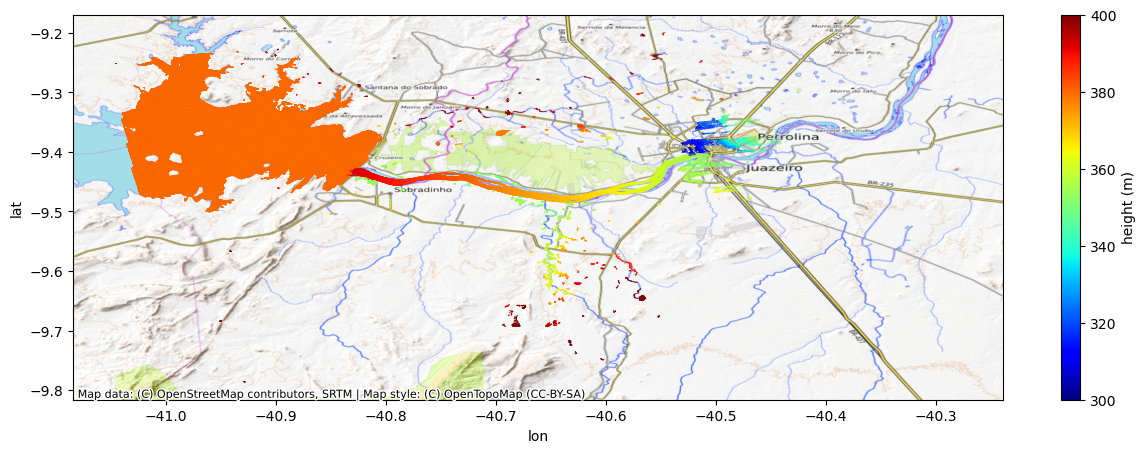

In [7]:
# Create a mask to filter out good water pixels based on classification and geolocation quality
# - ds_PIXC.classification > 2: selects pixels classified as water
# - ds_PIXC.geolocation_qual < 4: selects pixels with good geolocation quality
mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual <4))
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=ds_PIXC.longitude[mask], y=ds_PIXC.latitude[mask], c=ds_PIXC.height[mask],
           s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')

Converting a wrapped, ambiguous InSAR phase (known only within a 2π interval) to an absolute phase is known as phase unwrapping. Phase unwrapping errors happen when incorrect multiples of 2π are added to the wrapped phase, leading to errors in both height and geolocation. Note in the above image how the river at the outlet of the reservoir is unrealistically higher than the reservoir.  The large height offset, along with a large cross-track slope and a shifted geolocation (e.g., relative to the water in the basemap image) are characteristic signatures of a phase unwrapping error.  This can happen especially near dams where the water on both sides ends up in the same spatial phase unwrapping region.  In such a case as this, a single absolute ambiguity is assigned to the entire region that includes both the reservoir and the river, while the phase/height discontinuity at the dam is not well captured within one phase ambiguity.

The way to correct this is by splitting the region into two (i.e., one for the reservoir and one for the river) and assigning a separate phase ambiguity to each region (i.e., a different multiple of 2π).  We will do this processing in the slant-plane image (e.g., in radar coordinates) because the spatial connectedness/topology is preserved among adjacent pixels without the additional geolocation noise that exists in the phase-geolocated lat/lon projection.

#### Make function to map a PIXC variable to slant-plane/radar coordiantes

In [8]:
def toslant(pixc, key='height'):
    az = pixc.azimuth_index.astype(int)
    rng = pixc.range_index.astype(int)
    out = np.zeros((pixc.interferogram_size_azimuth + 1, pixc.interferogram_size_range + 1)) + np.nan
    # handle complex interferogram
    if key=='interferogram':
        out = out.astype('complex64')
        var = pixc[key][:,0] + 1j * pixc[key][:,1]
    else:
        var = pixc[key]
    out[az, rng] = var
    return out

#### Get the desired data variables in slant plane

In [9]:
height = toslant(ds_PIXC, key='height')
lat = toslant(ds_PIXC, key='latitude')
lon = toslant(ds_PIXC, key='longitude')
klass = toslant(ds_PIXC, key='classification')
region = toslant(ds_PIXC, key='phase_unwrapping_region')
dheight_dphase = toslant(ds_PIXC, key='dheight_dphase')
dlat_dphase = toslant(ds_PIXC, key='dlatitude_dphase')
dlon_dphase = toslant(ds_PIXC, key='dlongitude_dphase')
ifgram = toslant(ds_PIXC, key='interferogram')
power_plus_y = toslant(ds_PIXC, key='power_plus_y')
power_minus_y = toslant(ds_PIXC, key='power_minus_y')
cross_track = toslant(ds_PIXC, key='cross_track')

#### Plot the height image in slant-plane (for all pixels)

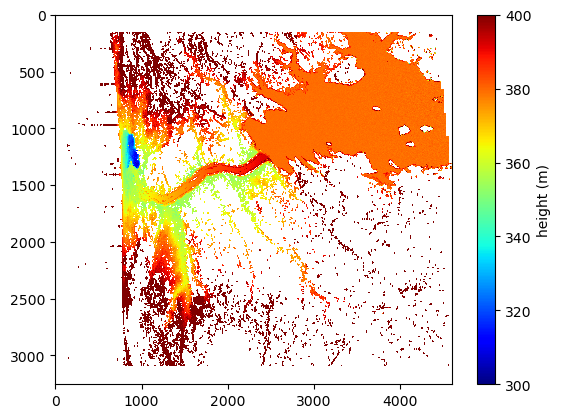

In [10]:
plt.imshow(height, interpolation='none', cmap='jet', aspect='auto')
plt.clim((300,400))
plt.colorbar().set_label('height (m)')

#### Plot the phase unwrapping regions
A key step in SWOT's phase unwrapping algorithm is to separate the image into regions where a single phase ambiguity is expected to be shared. These are referred to as "phase unwrapping regions" and are accessible in the PIXC product. Note that both the reservoir and the river both have the same phase unwrapping region id (e.g., region==2).

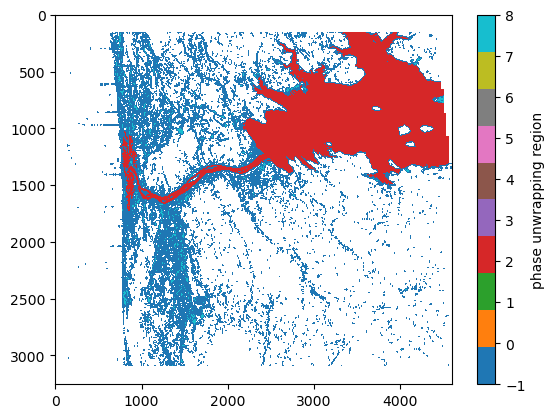

In [11]:
plt.imshow(region, interpolation='none', cmap='tab10', aspect='auto')
plt.clim((-1,8))
plt.colorbar().set_label('phase unwrapping region')

#### Get a mask for only the pixels in region 2

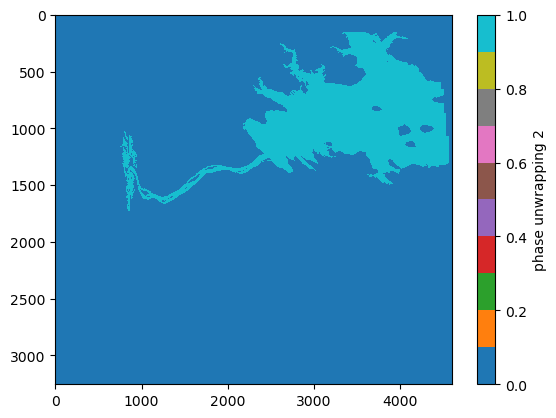

In [12]:
mask = np.where(region == 2)
region_mask = np.zeros_like(region)
region_mask[mask] = 1
plt.imshow(region_mask, interpolation='none', cmap='tab10', aspect='auto')
plt.colorbar().set_label('phase unwrapping 2')

### Plot the classification image
Water-water layover describes the phenomenon where multiple waterbodies are in layover. This is in contrast to land-water layover, where land overlies water. Note that when water-water layover occurs, the backscattering (i.e. sig0) is bright, but the coherence tends to be low (because the phase from the two laid-over water-bodies with different heights/phases mix together).  Water-water-layover tends to happen near dams/reservoir outlets, although it depends on the relative orientation in the swath.  When water-water-layover happens near a dam, the coherence tends to drop right near the transition between reservoir and river.  Thus, we can use the low-coherence water classes in the classification image to help split the regions in two.

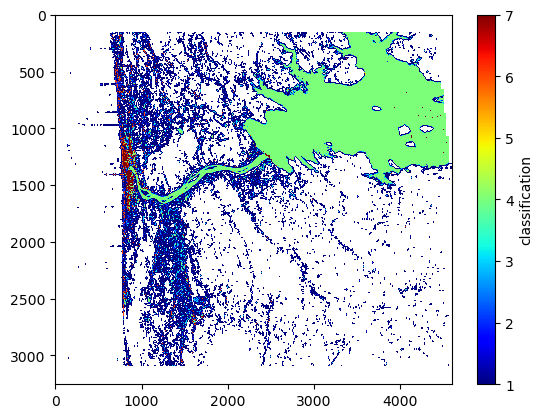

In [13]:
# plot the classification image
plt.imshow(klass, interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('classification')

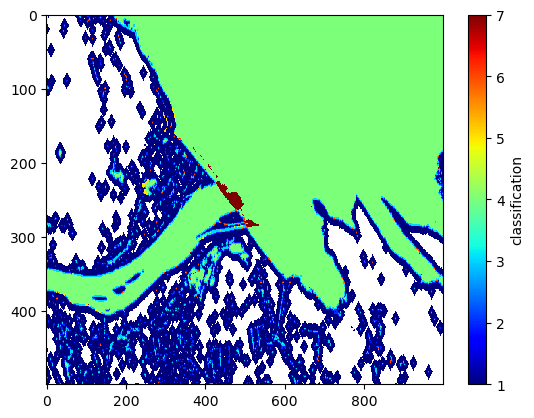

In [14]:
# zoom in around the dam
plt.imshow(klass[1000:1500,2000:3000], interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('classification')

### Use the low-coherence zone to break the image into multiple segments
As mentioned above, we expect water-water-layover near a dam to have a low-coherence zone the coherence right by the transition between reservoir and river. These low-coherence zones are assigned their own classification value in the PIXC product. Here, we use the low-coherence water classes in the classification image to help split the regions in two. This will address the problem where the river channel and reservoir share a phase unwrapping region.

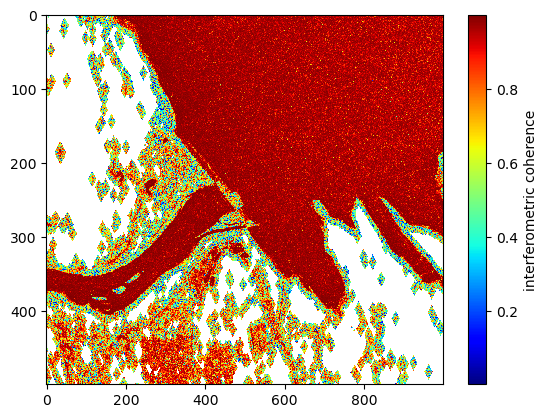

In [15]:
# plot the zoomed-in interferometric coherence for reference
coh = abs(ifgram) / np.sqrt(power_plus_y * power_minus_y)
plt.imshow(coh[1000:1500,2000:3000], interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('interferometric coherence')

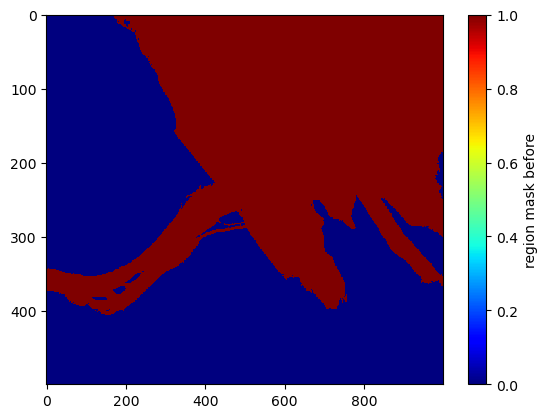

In [16]:
# plot the zoomed-in region mask for reference
plt.imshow(region_mask[1000:1500,2000:3000], interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('region mask before')

### Break the region at low-coherence/bright areas by zeroing out low-coherence areas from the mask

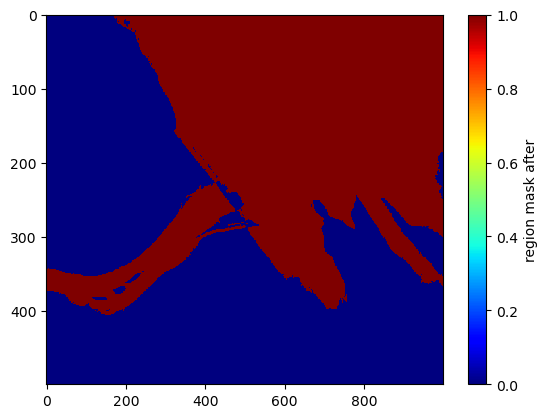

In [17]:
low_coh = np.zeros_like(region_mask)
#low_coh[coh<0.5] = 1
## do some dilations to make sure the water-water-layover area is chopped out
#low_coh = scipy.ndimage.binary_dilation(low_coh)
## dont do this close to swath edges since the coherence is lower there and we get a bunch of pixels detected as low-coherence
#low_coh [cross_track<20000] = 0
#low_coh [cross_track>80000] = 0
low_coh[klass>=6] = 1
region_mask[low_coh>0] = 0
plt.imshow(region_mask[1000:1500,2000:3000], interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('region mask after')

#### Now segment the mask into multiple disconnected regions

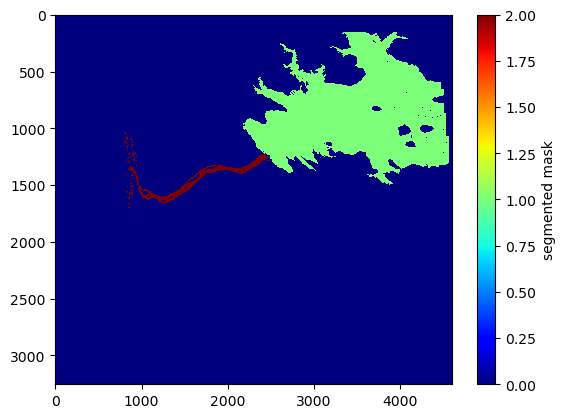

In [18]:
# segment the mask
lab, nlabs = scipy.ndimage.label(region_mask)
plt.imshow(lab, interpolation='none', cmap='jet', aspect='auto')
plt.clim((0,2))
plt.colorbar().set_label('segmented mask')

#### Split out the biggest segment (the reservoir) from the rest (river)

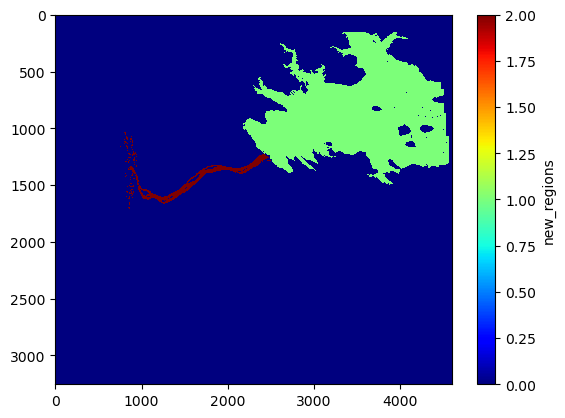

In [19]:
new_regions = np.zeros_like(region)
new_regions[lab==1] = 1 # the biggest one (i.e., the reservoir)
new_regions[lab>1] = 2 # the rest
plt.imshow(new_regions, interpolation='none', cmap='jet', aspect='auto')
plt.colorbar().set_label('new_regions')

#### Adjust the height and locations corresponding to 2π phase offsets
Note that this approach of moving along the geolocation sensitivities to phase (e.g., dheight_dphase, dlat_dphase, dlon_dphase) is an approximation.  The more robust thing to do would be to add/subtract 2π increments to the absolute phase and regeolocate each pixel.  The approximation is generally good if we are only moving a few ambiguities away, but gets worse if we need to move many multiples of 2π.

In [20]:
# set up some more masks
river_mask = np.zeros_like(new_regions) + np.nan
river_mask[new_regions==2] = 1
river_msk = river_mask==1
lake_msk = new_regions==1

#### Try adjusting the river region by +1 ambiguity

In [21]:
n = 1 # first, we try a +1 phase ambiguity
new_height = height + dheight_dphase * 2*n*np.pi
new_lat = lat + dlat_dphase * 2*n*np.pi
new_lon = lon + dlon_dphase * 2*n*np.pi

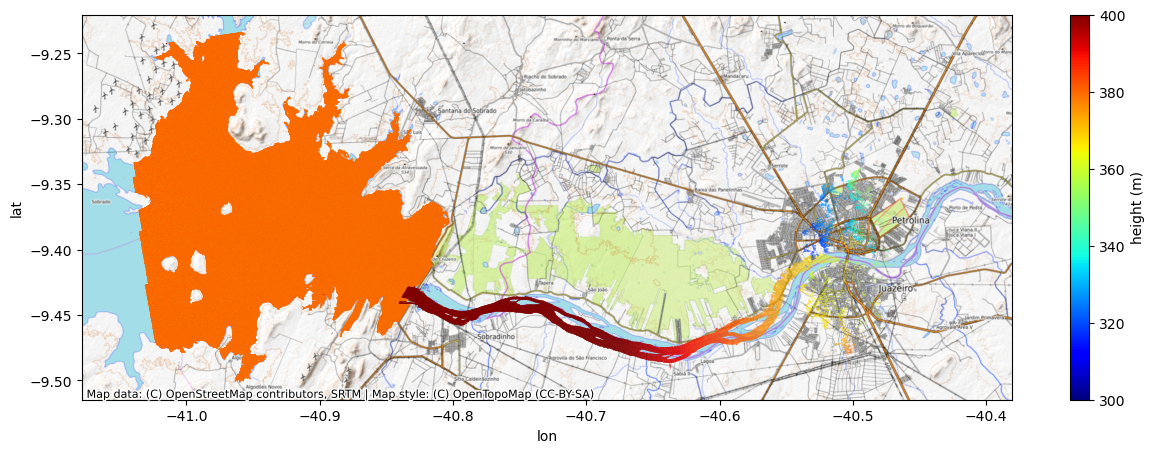

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
scat_lake = ax.scatter(lon[lake_msk], lat[lake_msk], c=height[lake_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
scat_river = ax.scatter(new_lon[river_msk], new_lat[river_msk], c=new_height[river_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
cbar = fig.colorbar(scat_lake, ax=ax)
cbar.set_label('height (m)')

Nope! By the bad geolocation and unrealistic river slope, we can see that made things worse.  

#### Try adjusting river by -1 ambiguity (in the other direction)

In [23]:
n = -1 # now, let's try a -1 phase ambiguity
new_height = height + dheight_dphase * 2*n*np.pi
new_lat = lat + dlat_dphase * 2*n*np.pi
new_lon = lon + dlon_dphase * 2*n*np.pi

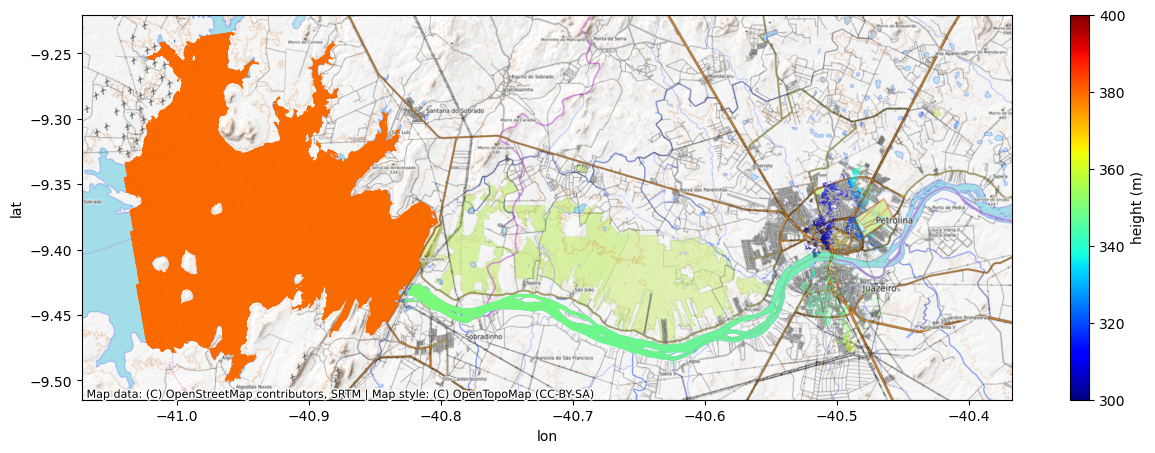

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
scat_lake = ax.scatter(lon[lake_msk], lat[lake_msk], c=height[lake_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
scat_river = ax.scatter(new_lon[river_msk], new_lat[river_msk], c=new_height[river_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
cbar = fig.colorbar(scat_lake, ax=ax)
cbar.set_label('height (m)')

That looks right.  The river lines up better with the basemap, the height and slope of the river seem more realistic.  But we should check the -2 ambiguity to be sure there is not an even better solution.

#### Try adjusting river by -2 ambiguities

In [25]:
n = -2. # now, let's try a -2 phase ambiguity 
new_height = height + dheight_dphase * 2*n*np.pi
new_lat = lat + dlat_dphase * 2*n*np.pi
new_lon = lon + dlon_dphase * 2*n*np.pi

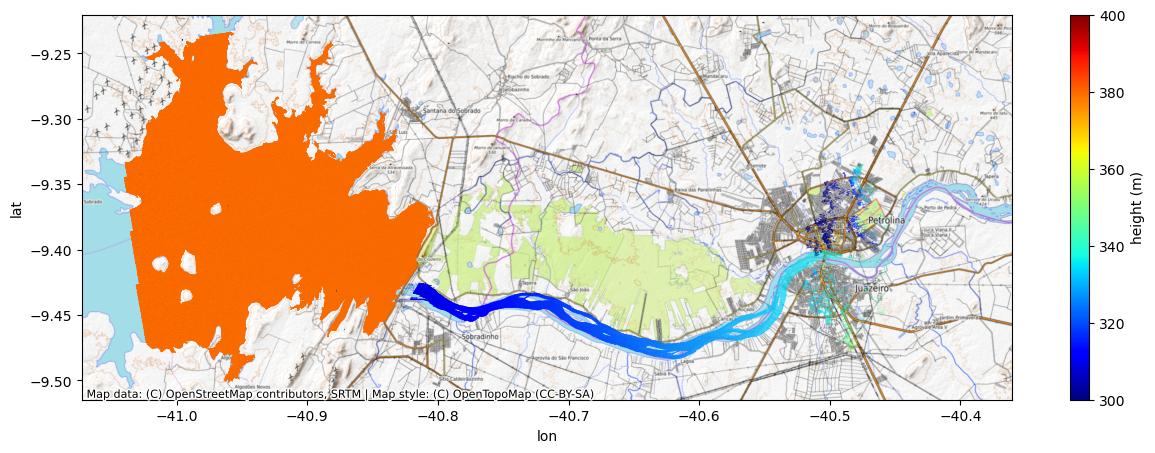

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
scat_lake = ax.scatter(lon[lake_msk], lat[lake_msk], c=height[lake_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
scat_river = ax.scatter(new_lon[river_msk], new_lat[river_msk], c=new_height[river_msk], s=0.1, edgecolor='none', cmap='jet', clim=(300,400))
cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
cbar = fig.colorbar(scat_lake, ax=ax)
cbar.set_label('height (m)')

Nope.  That's not it either.  Now the river is shifted too much in the other direction and has a large slope flowing the wrong way (into the reservoir).  This means that the best ambiguity for the river is -1!

#### Alternative Plots

In [27]:
# alternative plots with wrapped heights
# original ambiguity
#fig, ax = plt.subplots(figsize=(15,5))
#ax.scatter(lon[lake_msk], lat[lake_msk], c=np.mod(height[lake_msk],1), s=0.1, edgecolor='none', cmap='hsv', clim=(0,1))
#ax.scatter(lon[river_msk], lat[river_msk], c=np.mod(height[river_msk],1), s=0.1, edgecolor='none', cmap='hsv', clim=(0,1))
#cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, aspect='auto')
#ax.set_xlabel('lon')
#ax.set_ylabel('lat')
#fig.colorbar(scat).set_label('height (m), 1m wrap')

In [28]:
# adjusted ambiguity
#fig, ax = plt.subplots(figsize=(15,5))
#ax.scatter(lon[lake_msk], lat[lake_msk], c=np.mod(height[lake_msk],1), s=0.1, edgecolor='none', cmap='hsv', clim=(0,1))
#ax.scatter(new_lon[river_msk], new_lat[river_msk], c=np.mod(new_height[river_msk],1), s=0.1, edgecolor='none', cmap='hsv', clim=(0,1))
#cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap)
#ax.set_xlabel('lon')
#ax.set_ylabel('lat')
#fig.colorbar(scat).set_label('height (m), 1m wrap')